# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

# Install detectron2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

'2.2.2+cu121'

In [ ]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15528, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 15528 (delta 82), reused 186 (delta 42), pack-reused 15275
Receiving objects: 100% (15528/15528), 6.40 MiB | 27.65 MiB/s, done.
Resolving deltas: 100% (11196/11196), done.
Obtaining file:///content/detectron2_repo
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-non

In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("zerowaste_train", {}, "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/labels.json", "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/data")

In [ ]:
zerowaste_metadata = MetadataCatalog.get("zerowaste_train")
dataset_dicts = DatasetCatalog.get("zerowaste_train")

[04/07 19:55:59 d2.data.datasets.coco]: Loaded 3002 images in COCO format from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/labels.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



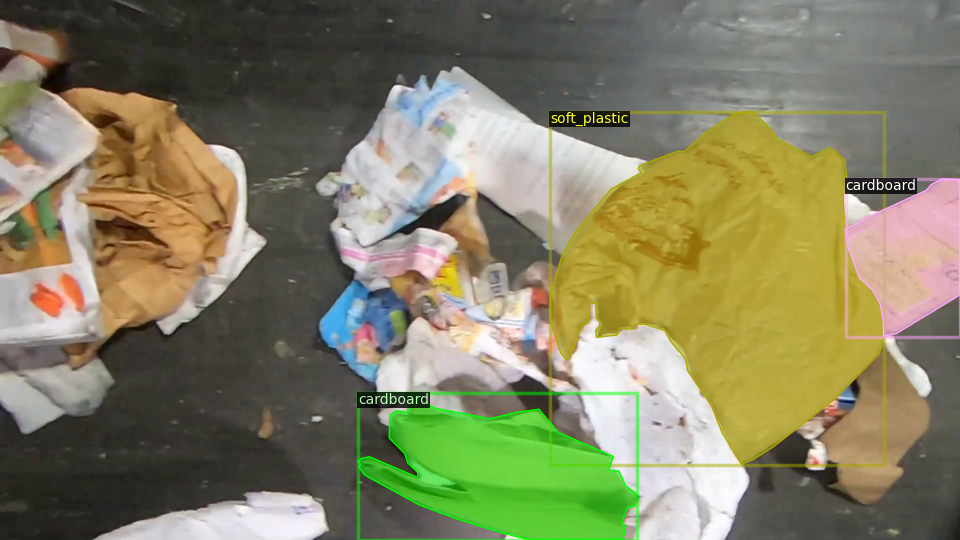

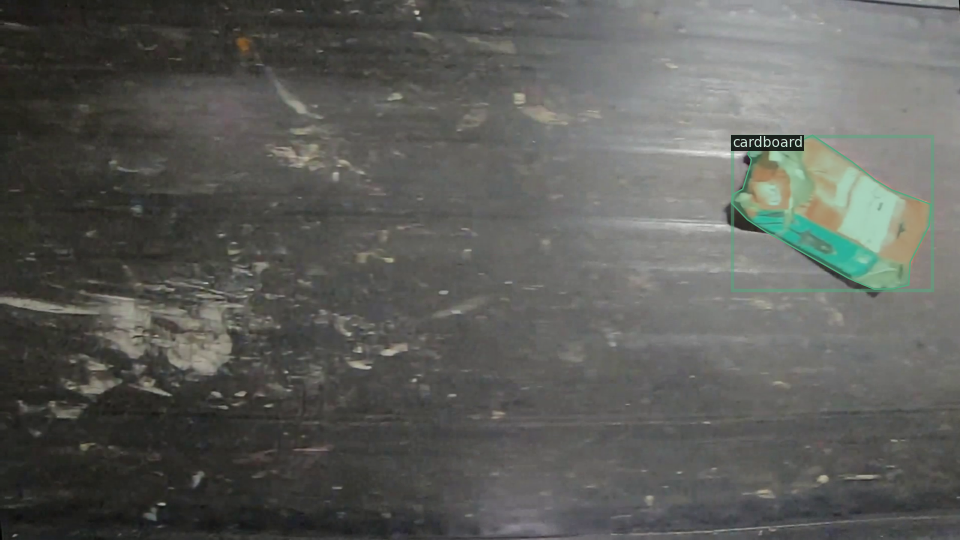

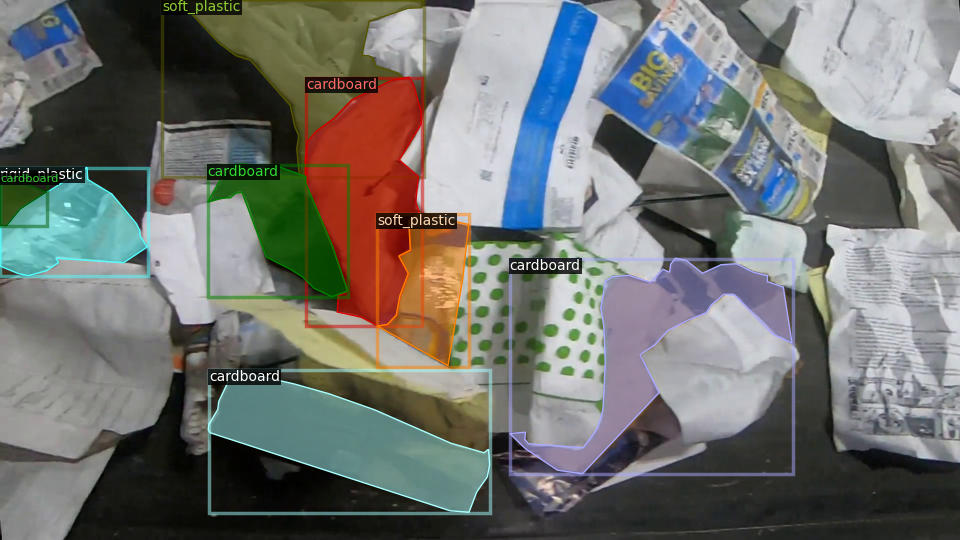

In [ ]:
import random

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=zerowaste_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("zerowaste_val", {}, "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/val/labels.json", "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/val/data")

In [ ]:
zerowaste_metadata_val = MetadataCatalog.get("zerowaste_val")
dataset_dicts_val = DatasetCatalog.get("zerowaste_val")

[04/07 19:56:13 d2.data.datasets.coco]: Loaded 572 images in COCO format from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/val/labels.json


In [ ]:
from detectron2.evaluation import COCOEvaluator
from detectron2.evaluation import DatasetEvaluators

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/Base-RetinaNet.yaml")
cfg.DATASETS.TRAIN = ("zerowaste_train",)
cfg.DATASETS.TEST = ("zerowaste_val",)   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/retinanet.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 1500   # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 300   # faster, and good enough for this toy dataset
cfg.MODEL.RETINANET.NUM_CLASSES = 4
cfg.OUTPUT_DIR = "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/RetinaNet"



In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)


[04/07 19:56:41 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

In [ ]:
trainer.train()

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("zerowaste_test", {}, "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/labels.json", "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/data")

In [ ]:
zerowaste_metadata_test = MetadataCatalog.get("zerowaste_test")
dataset_dicts_test = DatasetCatalog.get("zerowaste_test")

[04/07 19:56:26 d2.data.datasets.coco]: Loaded 929 images in COCO format from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/labels.json


In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/CMP-49413/zerowaste-f-final/RetinaNet/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.80
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("zerowaste_test", cfg, False, output_dir="/content/drive/MyDrive/CMP-49413/zerowaste-f-final/RetinaNet")
val_loader = build_detection_test_loader(cfg, "zerowaste_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/07 19:56:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/RetinaNet/model_final.pth ...
WARNING [04/07 19:56:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[04/07 19:56:49 d2.data.datasets.coco]: Loaded 929 images in COCO format from /content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/test/labels.json
[04/07 19:56:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/07 19:56:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/07 19:56:49 d2.data.common]: Serializing 929 elements to byte tensors and concatenating them all ...
[04/07 19:56:49 d2.data.common]: Serialized dataset takes 2.81 MiB
[04/07 19:56:49 d2.ev

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/07 19:56:52 d2.evaluation.evaluator]: Inference done 11/929. Dataloading: 0.0227 s/iter. Inference: 0.0420 s/iter. Eval: 0.0013 s/iter. Total: 0.0660 s/iter. ETA=0:01:00
[04/07 19:56:57 d2.evaluation.evaluator]: Inference done 75/929. Dataloading: 0.0359 s/iter. Inference: 0.0409 s/iter. Eval: 0.0006 s/iter. Total: 0.0775 s/iter. ETA=0:01:06
[04/07 19:57:02 d2.evaluation.evaluator]: Inference done 138/929. Dataloading: 0.0371 s/iter. Inference: 0.0407 s/iter. Eval: 0.0005 s/iter. Total: 0.0784 s/iter. ETA=0:01:02
[04/07 19:57:07 d2.evaluation.evaluator]: Inference done 202/929. Dataloading: 0.0378 s/iter. Inference: 0.0407 s/iter. Eval: 0.0005 s/iter. Total: 0.0791 s/iter. ETA=0:00:57
[04/07 19:57:12 d2.evaluation.evaluator]: Inference done 262/929. Dataloading: 0.0387 s/iter. Inference: 0.0408 s/iter. Eval: 0.0005 s/iter. Total: 0.0801 s/iter. ETA=0:00:53
[04/07 19:57:17 d2.evaluation.evaluator]: Inference done 323/929. Dataloading: 0.0390 s/iter. Inference: 0.0409 s/iter. Eval: 0

OrderedDict([('bbox',
              {'AP': 20.300917417611508,
               'AP50': 31.54210336534809,
               'AP75': 21.11171970985933,
               'APs': 9.851485148514852,
               'APm': 15.988488010235761,
               'APl': 21.238239958457797,
               'AP-rigid_plastic': 13.54546626477347,
               'AP-cardboard': 36.307071525611754,
               'AP-metal': 3.966293449054247,
               'AP-soft_plastic': 27.384838431006564})])

Then, we randomly select several samples to visualize the prediction results.

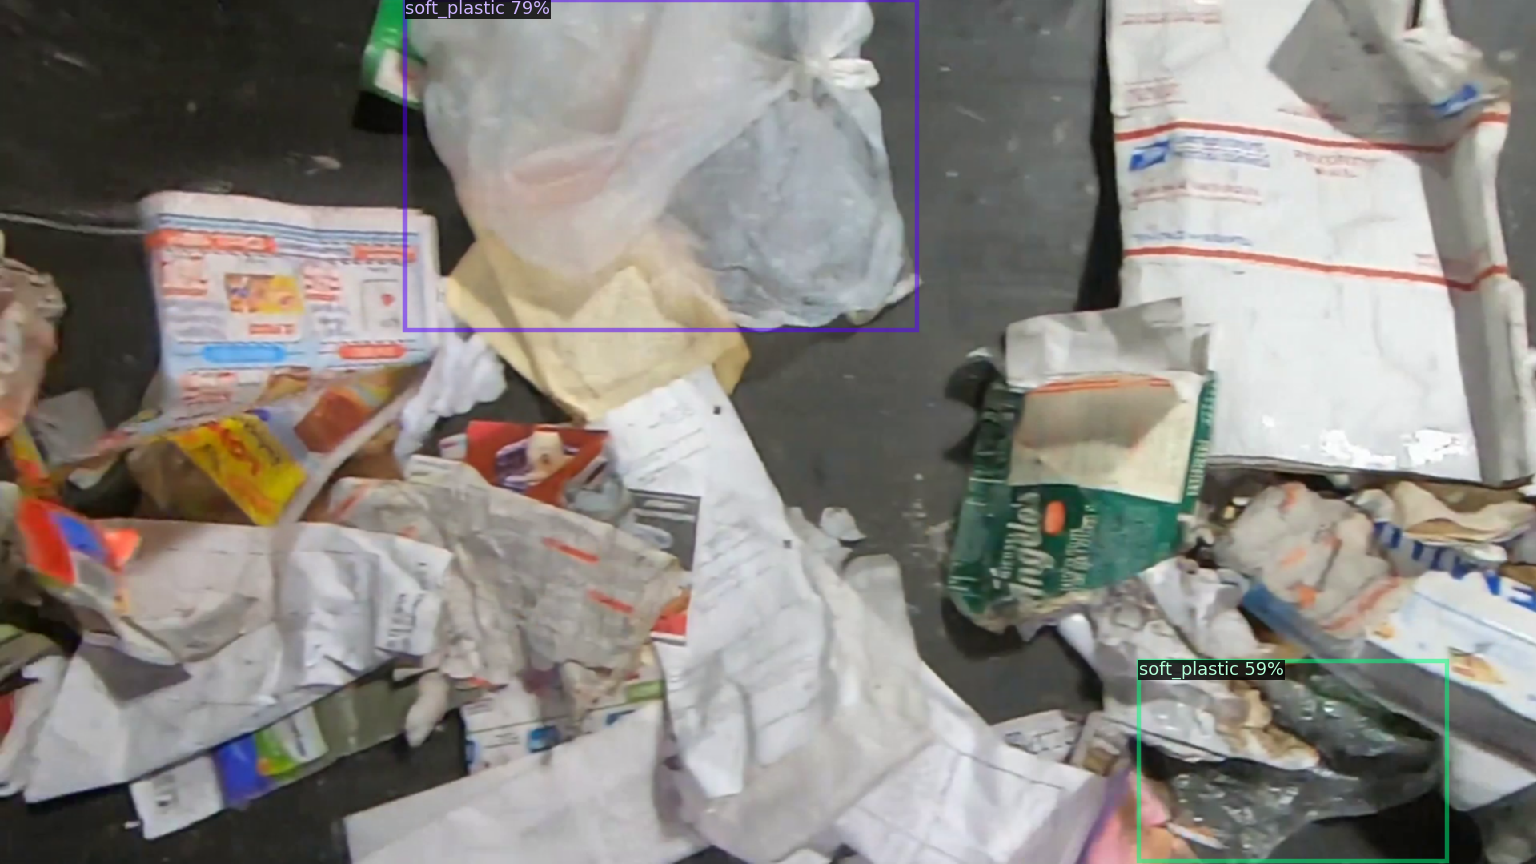

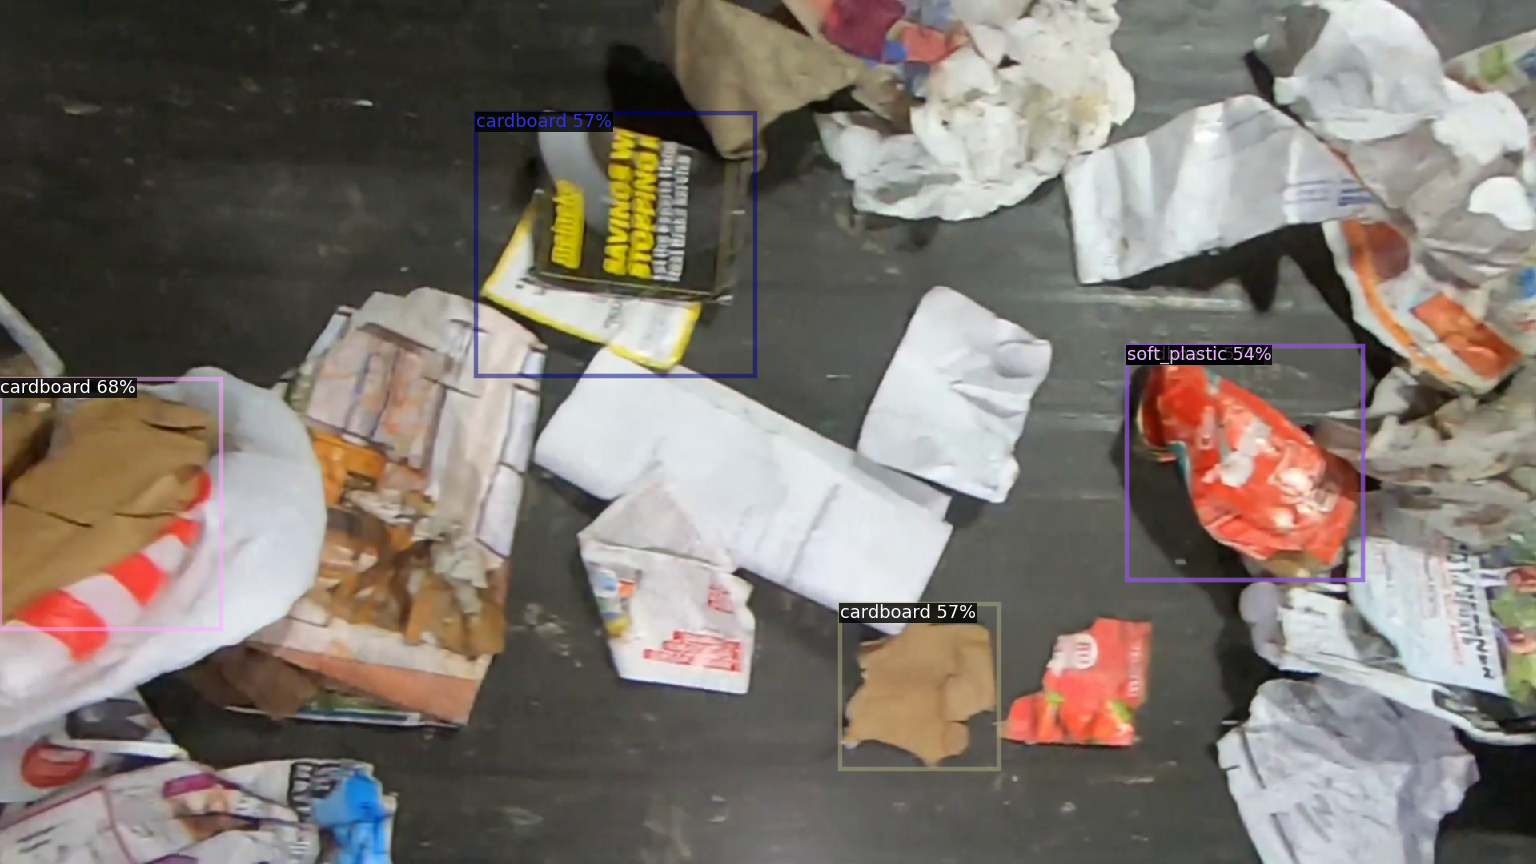

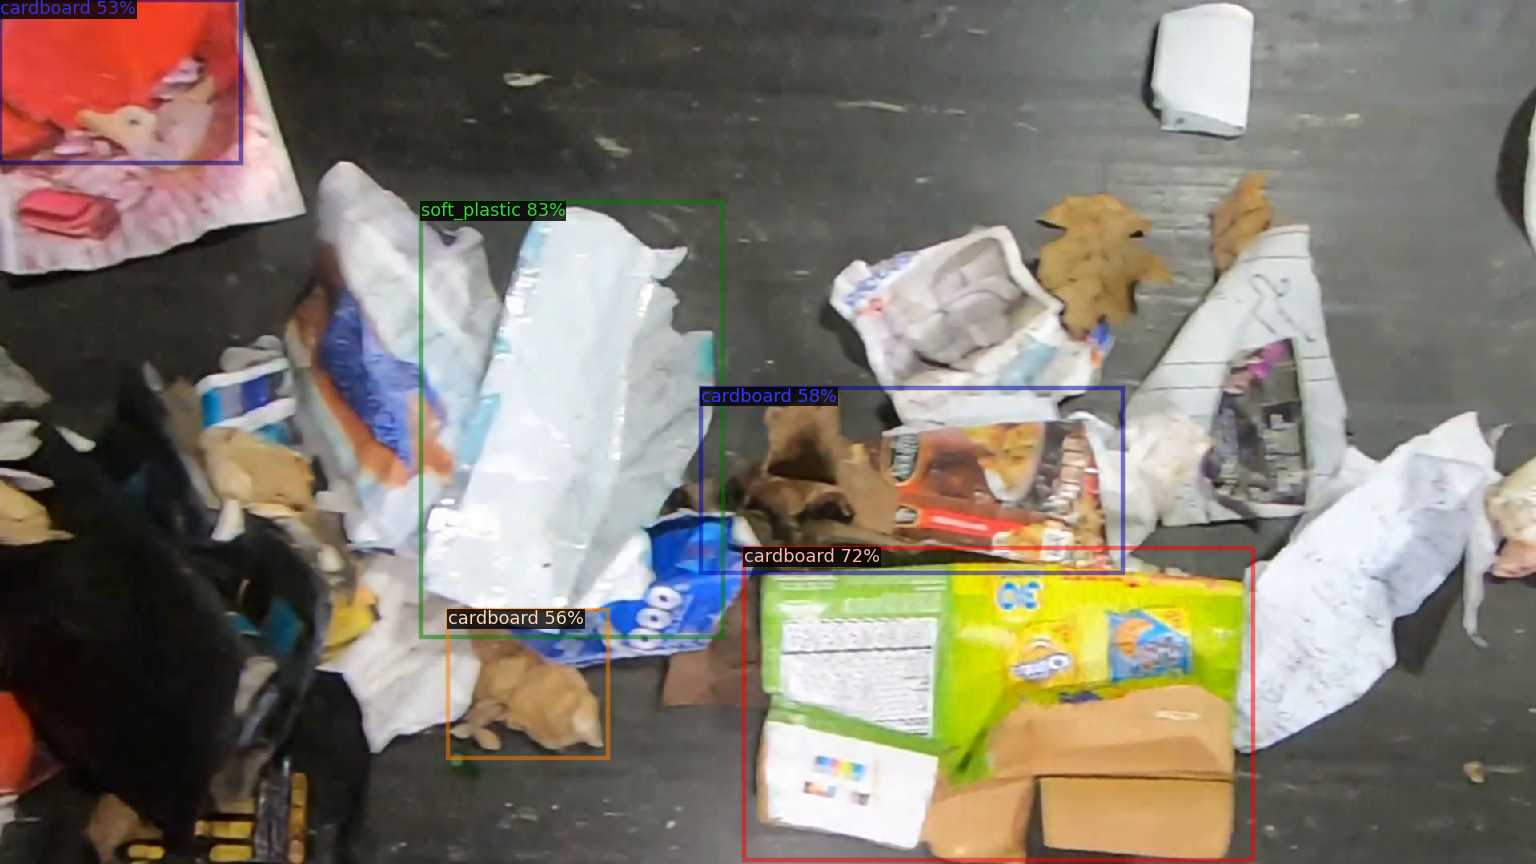

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)

    # Filter out boxes under 50% confidence level
    instances = outputs["instances"]
    scores = instances.scores
    mask = scores >= 0.5
    instances = instances[mask]

    v = Visualizer(im[:, :, ::-1],
                   metadata=zerowaste_metadata_test,
                   scale=0.8,
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(instances.to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


In [ ]:
zerowaste_metadata

namespace(name='zerowaste_train',
          json_file='/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/labels.json',
          image_root='/content/drive/MyDrive/CMP-49413/zerowaste-f-final/splits_final_deblurred/train/data',
          evaluator_type='coco',
          thing_classes=['rigid_plastic',
                         'cardboard',
                         'metal',
                         'soft_plastic'],
          thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3})

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))